In [3]:
#%matplotlib inline
%pylab inline
import numpy as np
import findspark
findspark.init()
import sys
import pylab as plt
from pickle import load
sys.path.append('./lib')
from numpy_pack import packArray,unpackArray
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot
from import_modules import import_modules,modules
import_modules(modules)
from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [28]:
sc.stop()

In [5]:
data_dir='../../Data/Weather'
file_index='SSSSBBBB'
m='SNWD'

filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
#print 'keys from STAT=',measurements

filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
df=df_in.filter(df_in.measurement==m)

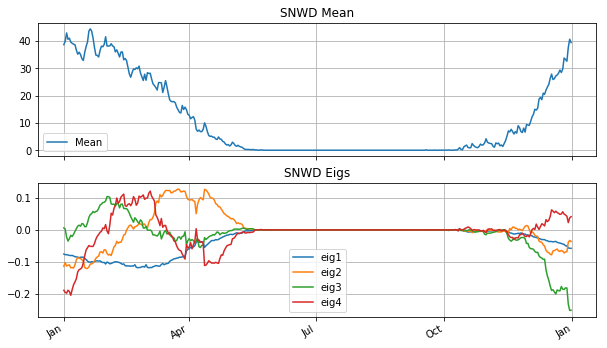

In [6]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [7]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

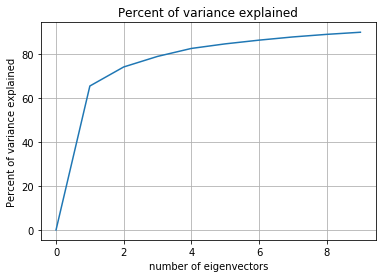

In [8]:
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

In [15]:
def decompose(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(coeff,res,rows,column_n=4, row_n=3, figsize=(15,10)):
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    cnum=coeff[-1]
    rnum=res[-1]
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='c%s=%3.2f,r%s=%3.2f'\
                    %(cnum,row[coeff],rnum,row[res])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None

def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()
    
def MS(Mat):
    return np.nanmean(Mat**2)

In [10]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)

print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1480
after filter 503


/Users/tak/anaconda/envs/CSE255/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


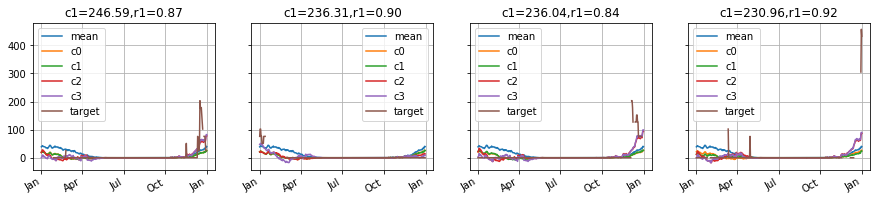

In [16]:
# Coeff1: most positive
df3=df3.sort(df3.coeff_1,ascending=False)
rows=df3.take(4)
plot_recon_grid('coeff_1','res_1',rows,row_n=1,figsize=(15,3))

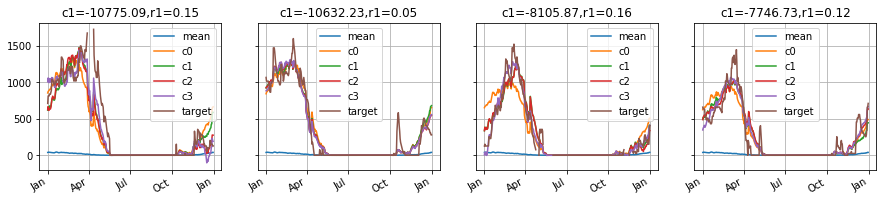

In [17]:
# Coeff1: most negative
df3=df3.sort(df3.coeff_1,ascending=True)
rows=df3.take(4)
plot_recon_grid('coeff_1','res_1',rows,row_n=1,figsize=(15,3))

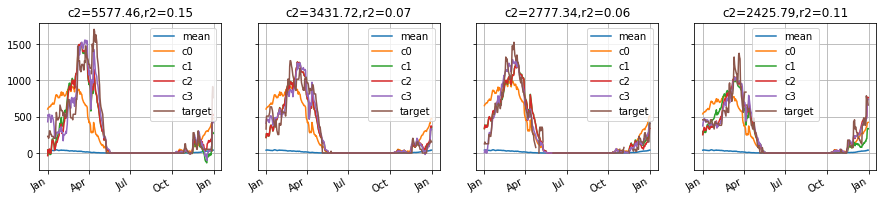

In [18]:
# Coeff2: most positive
df3=df3.sort(df3.coeff_2,ascending=False)
rows=df3.take(4)
plot_recon_grid('coeff_2','res_2',rows,row_n=1,figsize=(15,3))

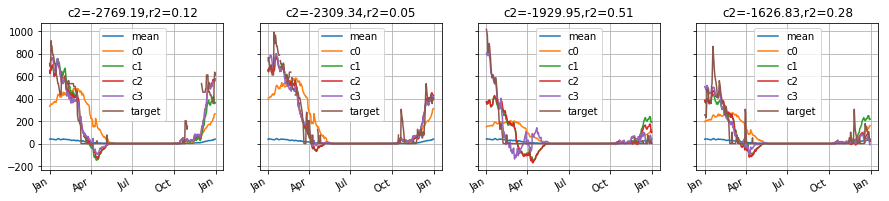

In [19]:
# Coeff2: most negative
df3=df3.sort(df3.coeff_2,ascending=True)
rows=df3.take(4)
plot_recon_grid('coeff_2','res_2',rows,row_n=1,figsize=(15,3))

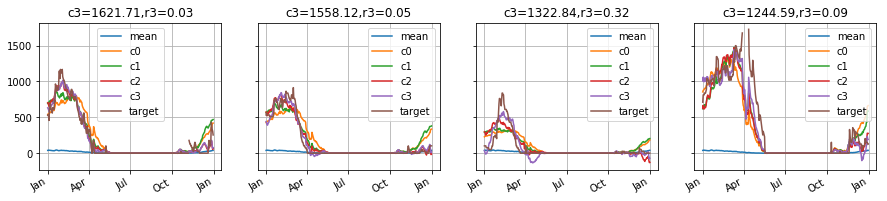

In [20]:
# Coeff3: most positive
df3=df3.sort(df3.coeff_3,ascending=False)
rows=df3.take(4)
plot_recon_grid('coeff_3','res_3',rows,row_n=1,figsize=(15,3))

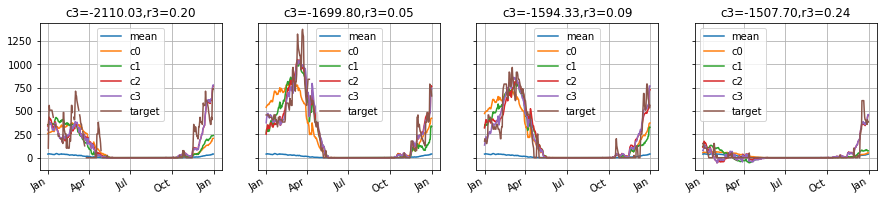

In [21]:
# Coeff3: most negative
df3=df3.sort(df3.coeff_3,ascending=True)
rows=df3.take(4)
plot_recon_grid('coeff_3','res_3',rows,row_n=1,figsize=(15,3))

In [10]:
df3=df3.sort(df3.res_3,ascending=True)

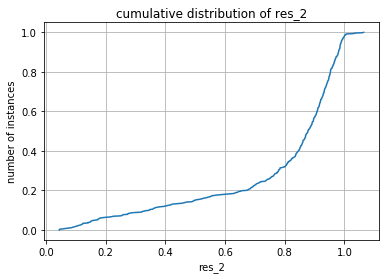

In [11]:
plot_CDF('res_2')

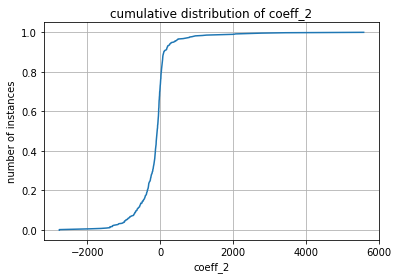

In [12]:
plot_CDF('coeff_2')

In [18]:
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,'SNWD')
df=sqlContext.read.parquet(filename)
Features='station, year, coeff_1,coeff_2,coeff_3,coeff_4'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT %s FROM weather"%Features
pdf = sqlContext.sql(Query).toPandas()

In [27]:
for coeff in ['coeff_1','coeff_2','coeff_3','coeff_4']:
    year_station_table=pdf.pivot(index='year', columns='station', values=coeff)
    mean_by_year=np.nanmean(year_station_table,axis=1)
    mean_by_station=np.nanmean(year_station_table,axis=0)
    tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
    tbl_minus_station = year_station_table-mean_by_station
    print coeff
    print 'total MS = ',round(MS(year_station_table),2)
    print 'MS removing mean-by-station =',round(MS(tbl_minus_station),2),'fraction explained =',round(100*(1-MS(tbl_minus_station)*1.0/MS(year_station_table)),1)
    print 'MS removing mean-by-year =',round(MS(tbl_minus_year),2),'fraction explained =',round(100*(1-MS(tbl_minus_year)*1.0/MS(year_station_table)),1)
    print

coeff_1
total MS =  2224620.21
MS removing mean-by-station = 757518.98 fraction explained = 65.9
MS removing mean-by-year = 1802372.5 fraction explained = 19.0

coeff_2
total MS =  318159.53
MS removing mean-by-station = 264675.69 fraction explained = 16.8
MS removing mean-by-year = 211595.75 fraction explained = 33.5

coeff_3
total MS =  171991.62
MS removing mean-by-station = 160686.79 fraction explained = 6.6
MS removing mean-by-year = 88446.98 fraction explained = 48.6

coeff_4
total MS =  144836.92
MS removing mean-by-station = 135086.69 fraction explained = 6.7
MS removing mean-by-year = 82249.19 fraction explained = 43.2

